# Clifford Data Regression(CDR)

This code is modification of the code provided in https://github.com/renatawong/clifford-data-regression-qiskit/blob/main/Clifford_data_regression_Qiskit.ipynb

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

# imports for generating training circuits
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import numpy as np
import random
from random import choices

Calculate expectation value from counts

In [91]:
nqubits = 2
nshots = 20000

def getParity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity


import itertools
def expectation_value_from_counts(counts):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if getParity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if getParity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots

Mapping circuit to near Clifford circuits with N = number of non-Clifford gates Z gates with these angles/exponents are Clifford gates.

In [92]:
clifford_exponents = np.array([0.0, 0.5, 1.0, 1.5])
clifford_angles = [exponent * np.pi for exponent in clifford_exponents]

Replacing some non-Clifford gates with Clifford gates in the input circuit


In [93]:
class RZTranslator(TransformationPass):
    """A transpiler pass to replace RZ(a) gates with RZ(pi/2)^n gates, for n = 0, 1, 2, 3 at random."""

    def run(self, dag):
        N = 0.3                                   # TUNABLE: here, replace 30% of the non-Clifford gates
        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RZ gate replace it by RZ(pi/2)^n at random
            if node.op.name in ["rz"]:
                # get the rotation angle
                angle = node.op.params[0]

                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rz":
                    if angle not in clifford_angles:
                        if choices([0,1], [N, 1-N])[0] == 0:
                            replacement.rz(random.choice(clifford_angles),0)
                        else:
                            replacement.rz(angle,0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        
        return dag

Least-squares regression from scipy


In [15]:
import scipy

def least_squares_regression(noiseless_exp_vals, noisy_exp_vals):
    result = scipy.stats.linregress(noisy_exp_vals, noiseless_exp_vals)
    return (result.slope, result.intercept)

Creating a circuit for CDR testing

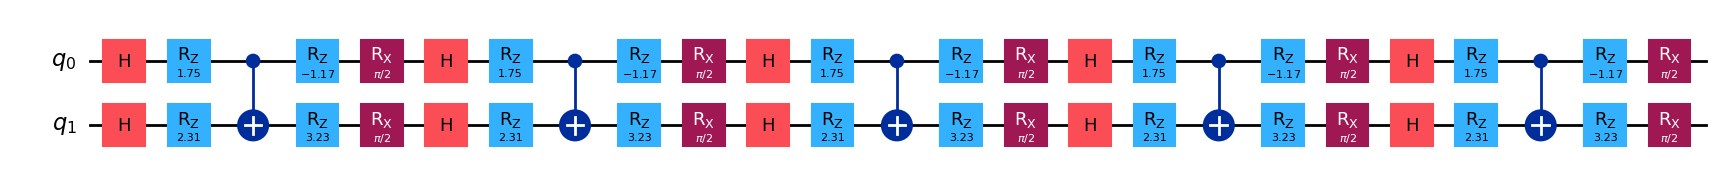

In [17]:
def append_gates(qc):
    for rep in range(5):
        for qubit in range(nqubits):
            qc.h(qubit)  
        for qubit in range(nqubits)[::2]:
            qc.rz(1.75, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(2.31, qubit)
        for qubit in range(nqubits)[::2]:
            qc.cx(qubit, qubit+1)     
        for qubit in range(nqubits)[::2]:
            qc.rz(-1.17, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(3.23, qubit)
        for qubit in range(nqubits):
            qc.rx(np.pi/2, qubit)    
    return qc

# The original vcircuit
qc = QuantumCircuit(nqubits)
append_gates(qc)
display(qc.draw('mpl'))

Outputs training circuit without measurement

In [105]:
training_circuits_no_measurement_all = []
num_train_circuits = 500
for _ in range(num_train_circuits):
    training_circuits_no_measurement_all.append(RZTranslator()(qc))

# print(*training_circuits_no_measurement_all)

Wrapping the circuit into a statefunction. This does not take simulation output into account, hence is always the same, while simulation with measurement. This is done to get the exact expectation value calculated through classical computer.

In [106]:
# from qiskit.opflow import Z, StateFn, CircuitStateFn
from qiskit.quantum_info import Statevector, Pauli, Operator

Z = Pauli('Z')

# creating a two qubit observable with Z tensor Z
# observable = Z ^ 2
observable = Z.tensor(Z)
observable_operator = Operator(observable)

# expectation value of the original circuit
# psi_qc = CircuitStateFn(qc)
psi_qc = Statevector(qc)

# exp_val_qc = (~psi_qc @ observable @ psi_qc).eval()
exp_val_qc = psi_qc.expectation_value(observable_operator)


print('Exact expectation value of circuit of interest:', exp_val_qc.real)

noiseless_exp_vals = []   
training_circuits_no_measurement = []
for circuit in training_circuits_no_measurement_all: 
    # psi = CircuitStateFn(circuit)
    psi = Statevector(circuit)
    # expectation_value = (~psi @ observable @ psi).eval()
    # expectation_value = np.real(np.vdot(psi_qc, observable.to_matrix() @ psi_qc))
    expectation_value = psi.expectation_value(observable_operator)


    if expectation_value >= exp_val_qc.real-0.05 and expectation_value <= exp_val_qc.real+0.05:
        noiseless_exp_vals.append(expectation_value.real)
        training_circuits_no_measurement.append(circuit)


for exp_val in noiseless_exp_vals:
    print('Exact expectation value:', exp_val)

Exact expectation value of circuit of interest: 0.20422260124463626
Exact expectation value: 0.19770118160683586
Exact expectation value: 0.2095416847757512
Exact expectation value: 0.16565860407573957
Exact expectation value: 0.22253257080736838
Exact expectation value: 0.246421872124851
Exact expectation value: 0.22191810428292588
Exact expectation value: 0.2420735184957917
Exact expectation value: 0.24212885718168975
Exact expectation value: 0.18696839934546422
Exact expectation value: 0.18675507118681944
Exact expectation value: 0.1748159029813842
Exact expectation value: 0.20803097999284717
Exact expectation value: 0.2138123903202113
Exact expectation value: 0.22691778380820884
Exact expectation value: 0.23820983325921935
Exact expectation value: 0.1734037014706462
Exact expectation value: 0.2255885108752031
Exact expectation value: 0.23682341395200351
Exact expectation value: 0.2302871514278068
Exact expectation value: 0.17775584684580822
Exact expectation value: 0.18019437570588

Generate training circuits with measurement for noisy simulation on quantum devices


In [107]:

from qiskit import ClassicalRegister

# original circuit with measurement
qr_qc = QuantumRegister(nqubits)
cr_qc = ClassicalRegister(nqubits)
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])
circ_qc.measure(qr_qc, cr_qc)

training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), [qubit for qubit in range(nqubits)])
    circ.measure(qr, cr) 
    training_circuits_with_measurement.append(circ)
    
print(*training_circuits_with_measurement)

      ┌──────────────┐┌─┐   
q1_0: ┤0             ├┤M├───
      │  circuit-163 │└╥┘┌─┐
q1_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c1: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q2_0: ┤0             ├┤M├───
      │  circuit-163 │└╥┘┌─┐
q2_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c2: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q3_0: ┤0             ├┤M├───
      │  circuit-163 │└╥┘┌─┐
q3_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c3: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q4_0: ┤0             ├┤M├───
      │  circuit-163 │└╥┘┌─┐
q4_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c4: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q5_0: ┤0             ├┤M├───
      │  circuit-163 │└╥┘┌─┐
q5_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c5: 2/═════════════════╩══╩═
              

Adding noise model to our simulation on noisy backend

In [109]:
from qiskit import transpile

from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeVigo

from qiskit_aer import AerSimulator

device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)

noisy_exp_vals = []   
for circuit in training_circuits_with_measurement: 
    tqc = transpile(circuit, sim_vigo) 
    result_noise = sim_vigo.run(tqc, shots=nshots).result() 
    counts_noise = result_noise.get_counts(0) 
    noisy_exp_val = expectation_value_from_counts(counts_noise) 
    print('Noisy expectation value from counts: ', noisy_exp_val)
    noisy_exp_vals.append(noisy_exp_val)

Noisy expectation value from counts:  0.1255
Noisy expectation value from counts:  0.164
Noisy expectation value from counts:  0.1102
Noisy expectation value from counts:  0.1634
Noisy expectation value from counts:  0.1685
Noisy expectation value from counts:  0.1691
Noisy expectation value from counts:  0.1719
Noisy expectation value from counts:  0.1879
Noisy expectation value from counts:  0.1406
Noisy expectation value from counts:  0.1516
Noisy expectation value from counts:  0.1094
Noisy expectation value from counts:  0.1552
Noisy expectation value from counts:  0.136
Noisy expectation value from counts:  0.1558
Noisy expectation value from counts:  0.1879
Noisy expectation value from counts:  0.1158
Noisy expectation value from counts:  0.1654
Noisy expectation value from counts:  0.175
Noisy expectation value from counts:  0.1802
Noisy expectation value from counts:  0.115
Noisy expectation value from counts:  0.1161
Noisy expectation value from counts:  0.1149
Noisy expectat

Prepare least square regression

In [110]:
import scipy

result = least_squares_regression(noiseless_exp_vals, noisy_exp_vals)

slope = result[0]
intercept = result[1]
print('Slope: ', slope, ' Intercept: ', intercept)


Slope:  0.961857906804564  Intercept:  0.06471207994807329


Fit a line using the slope and intercept derived above

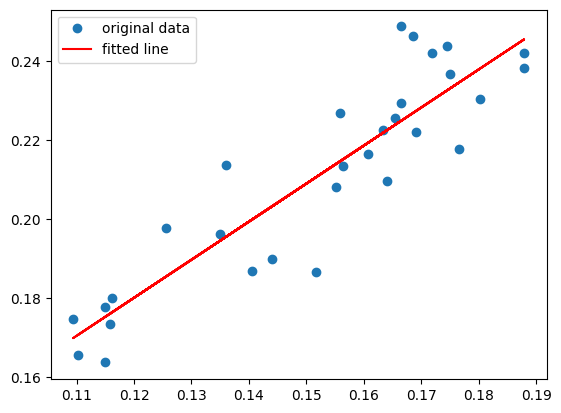

In [111]:
import matplotlib.pyplot as plt
plt.plot(noisy_exp_vals, noiseless_exp_vals, 'o', label='original data')
noisy_exp_vals = np.array(noisy_exp_vals)
plt.plot(noisy_exp_vals, slope*noisy_exp_vals + intercept, 'r', label='fitted line')

plt.legend()
plt.show()

Prediction: run the original circuit and measure (= X_exact). 
Then, apply the function X_exact = slope*X_noisy + intercept to obtain the mitigated value. 

In [123]:
# Running classical simulation
from qiskit.visualization import plot_histogram

# Testing: classical exact expectation value from the original circuit
psi_test = Statevector(qc)
# exact_exp_val_test = (~psi_test @ observable @ psi_test).eval().real
exact_exp_val_test =  psi_test.expectation_value(observable_operator).real
print('Exact expectation value: ', exact_exp_val_test)

Exact expectation value:  0.20422260124463626


Testing: quantum noisy expectation value on the original circuit


In [128]:
device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)
tqc = transpile(circ_qc, sim_vigo) 
result_noise = sim_vigo.run(tqc, shots=nshots).result() 
counts_noise = result_noise.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(counts_noise) 


# Mitigation
mitigated_exp_val = slope*unmitigated_exp_val + intercept
print('Mitigated expectation value from counts:', mitigated_exp_val)

# Error calculation
error_unmitigated = abs(unmitigated_exp_val-exact_exp_val_test)
error_mitigated = abs(mitigated_exp_val-exact_exp_val_test)
print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with CDR):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated/exact_exp_val_test))
print("Relative error (mitigated with CDR):", error_mitigated/exact_exp_val_test)

print(f"Error reduction with CDR: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")

Mitigated expectation value from counts: 0.20658612120174646
Error (unmitigated): 0.05672260124463627
Error (mitigated with CDR): 0.002363519957110205
Relative error (unmitigated): 0.27774889213505227
Relative error (mitigated with CDR): 0.011573253610059385
Error reduction with CDR: 95.8%.
